We'll be doing the inverse modeling exercise presented in ADCME but using pytorch. Reference script is:

https://kailaix.github.io/ADCME.jl/dev/exercise/

# Libraries


In [1]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation
from scipy.stats import norm
import pandas as pd
import torch
from torch import nn
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import Adam
import itertools

# Load data

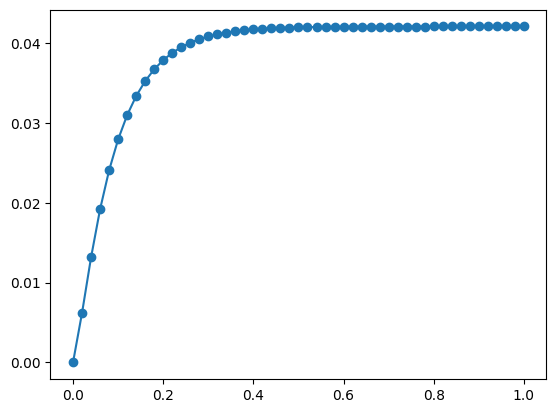

In [2]:
data_loc = "Exercise/Code and data/1DCase/data.txt"
temperature_data = []
with open(data_loc) as f:
    for val in f.readlines():
        temperature_data.append(2*float(val.replace("\n","")))
df = pd.DataFrame({
    "temperature":temperature_data
})
df['time'] = np.linspace(0,1,len(temperature_data))
plt.plot(df['time'],df['temperature'],'o-')

# Penalty method

We will be using the penalty method, which doesn't involve having to actually solve the ODE

In [3]:
L = 1.0
Nx = 20
Nt = len(df['time'])
delx = L/Nx 
delt = df['time'][1] - df['time'][0]

In [4]:
# Register the parameters
theta = nn.Parameter(0.1*torch.ones(2,1))
U = nn.Parameter(torch.zeros(Nx,Nt))

In [5]:
print(f"Total number of parameters are: {U.size()[0]*U.size()[1] + len(theta)}")

Total number of parameters are: 1022


In [6]:
# Create the discretisation grid
t_mesh = torch.from_numpy(np.array(df['time'])).float()
x_mesh = torch.linspace(0,1,Nx)

In [7]:
def forceing(x):
    return torch.exp(-10*(x-0.5)**2) 
F = forceing(x_mesh)
boundary_data = torch.from_numpy(np.array(df['temperature'])).float()

In [8]:
def pad_lower(a_lower):
    upper_pad = torch.zeros(1,a_lower.size()[0])
    right_pad = torch.zeros(a_lower.size()[0]+1,1)
    temp = torch.vstack((upper_pad,a_lower))
    return torch.hstack((temp,right_pad))
    
def pad_upper(a_upper):
    left_pad = torch.zeros(a_upper.size()[0],1)
    lower_pad = torch.zeros(1,a_upper.size()[0]+1)
    temp = torch.hstack((left_pad,a_upper))
    return torch.vstack((temp,lower_pad))
    


In [9]:
mask = torch.ones(Nx-1)
mask[0] = 2

# Setting up the calculation
def compute_loss():

    K = theta[0] + theta[1]*x_mesh
    lam = delt * K / delx**2
    A_diag = torch.diag(1.0+2.0*lam)
    A_lower = pad_lower(torch.diag(-lam[1:]))
    A_upper = pad_upper(torch.diag(-lam[:-1]*mask))
    A = A_diag + A_upper + A_lower
    
    loss_pde = 0 
    for k in range(1,Nt):
        L = torch.mm(A,U[:,k][:,None]) - U[:,k-1][:,None] - delt*F[:,None]
        loss_pde += torch.mm(L.transpose(0,1),L).squeeze()
    loss_boundary_0 =(U[0,:]-boundary_data).pow(2).sum()
    loss_boundary_1 =(U[-1,:]-torch.zeros(Nt)).pow(2).sum()
    loss_boundary_2 =(U[:,0]-torch.zeros(Nx)).pow(2).sum()
    return loss_pde +loss_boundary_0+loss_boundary_1 + loss_boundary_2


In [10]:
def optimise(optimiser):
    optimiser.zero_grad()
    loss = compute_loss()
    loss.backward()
    optimiser.step()
    return loss

In [11]:
lr = 0.01
epochs = 5000
learnable_params = itertools.chain((theta,),(U,))
optimizer = Adam(learnable_params, lr=lr)


In [12]:
loss_vector = []
iteration_vector =[]
for i in range(epochs):
    loss = optimise(optimizer)
    if i % 100==0:
        iteration_vector.append(i)
        loss_vector.append(loss.detach().numpy())
        print(i,loss.detach().numpy())

0 0.22816727
100 0.0940672
200 0.06153804
300 0.036714047
400 0.020198906
500 0.010546326
600 0.0054305405
700 0.0029771433
800 0.0019405662
900 0.0009261069
1000 0.0006499308
1100 0.00037801123
1200 0.0002897621
1300 0.0004263563
1400 0.00037522393
1500 0.00029207752
1600 0.00027279978
1700 0.00048854016
1800 0.0003877625
1900 0.00020576947
2000 0.00014049327
2100 0.00096350606
2200 0.00019966738
2300 0.0002267434
2400 0.00014074864
2500 0.00013786314
2600 0.00087815063
2700 0.00030840465
2800 0.00015013659
2900 0.00027399723
3000 0.0013516347
3100 0.00051659945
3200 0.0001738818
3300 0.00012532965
3400 0.00026668567
3500 0.00048141283
3600 0.00016458113
3700 0.00045742106
3800 0.00023030155
3900 0.0005085751
4000 0.00024623337
4100 0.0001586702
4200 0.0004996599
4300 0.0007189886
4400 0.00045016664
4500 0.00013102447
4600 0.00014616418
4700 0.0010124386
4800 0.00018898737
4900 0.0006130034


Text(0, 0.5, 'x')

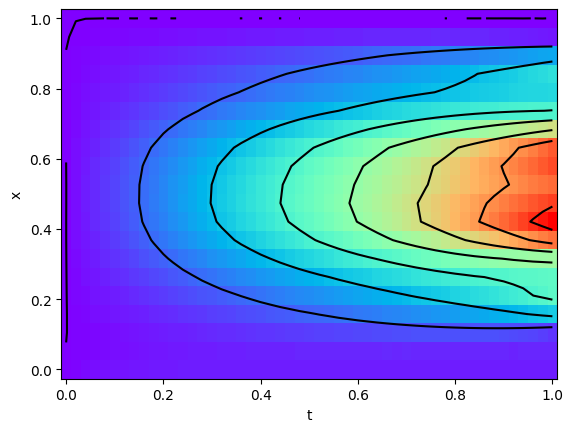

In [13]:
solution = U.detach().numpy()
tt,xx = np.meshgrid(t_mesh.numpy().squeeze(),x_mesh.numpy().squeeze())
plt.pcolormesh( tt,xx, solution,cmap='rainbow')
plt.contour(tt,xx, solution, 10, colors='k')
plt.xlabel("t")
plt.ylabel('x')

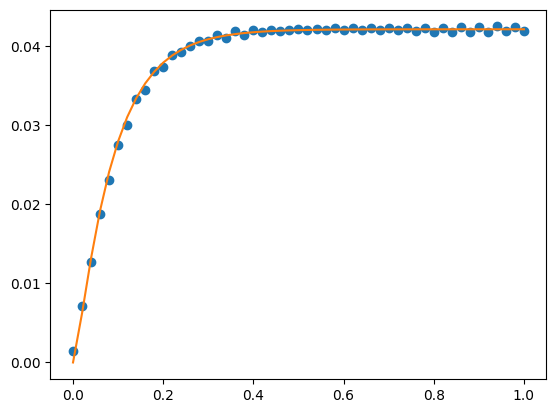

In [14]:
boundary = U[0,:].detach().numpy()
plt.plot(t_mesh.numpy(),boundary,'o')
plt.plot(df['time'],df['temperature'],'-')

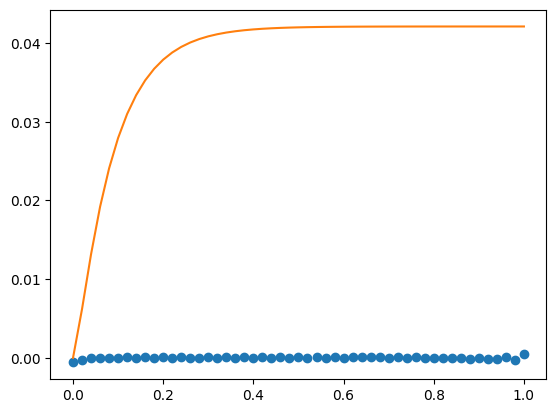

In [15]:
boundary = U[-1,:].detach().numpy()
plt.plot(t_mesh.numpy(),boundary,'o')
plt.plot(df['time'],df['temperature'],'-')

In [16]:
theta

Parameter containing:
tensor([[-0.0087],
        [ 0.0035]], requires_grad=True)

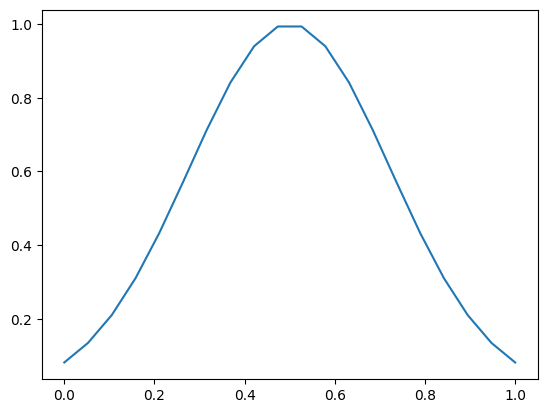

In [17]:
plt.plot(x_mesh.numpy(),F.numpy())
